# The ML Pipeline for a Model to Predict Length of Hospital Delivery Stay

In [31]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib
from math import ceil
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import PredefinedSplit

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import ParameterGrid

from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost

import shap

# Gather Data

In [32]:
# specifying data types for the columns to maintain formatting from original data
data_types = {
    'hospital_service_area': object, 
    'hospital_county': object,
    'operating_certificate_number': object, 
    'permanent_facility_id': object,
    'facility_name': object, 
    'age_group': object, 
    'zip_code_3_digits': object, 
    'gender': object, 
    'race': object,
    'ethnicity': object, 
    'payment_typology_1': object, 
    'payment_typology_2': object,
    'payment_typology_3': object, 
    'length_of_stay': int
}

In [33]:
all_visits = pd.read_csv('../data/planned_deliveries.csv', dtype=data_types)
all_visits = all_visits.loc[:, all_visits.columns != 'Unnamed: 0']
y = all_visits['length_of_stay']
X = all_visits.loc[:, all_visits.columns != 'length_of_stay']
X = X.loc[:, X.columns != 'operating_certificate_number']
X = X.loc[:, X.columns != 'facility_name']

# Compute Baseline Score

In [34]:
mean_length_of_stay = np.mean(y)
median_length_of_stay = np.median(y)
print('Mean length of stay:', mean_length_of_stay)
print('Median length of stay:', median_length_of_stay)

Mean length of stay: 2.3057860029780897
Median length of stay: 2.0


In [35]:
y_pred_mean = pd.Series([mean_length_of_stay]*len(y))

#### RMSE [days]

In [36]:
baseline_rmse = mean_squared_error(y, y_pred_mean, squared=False)
print('Baseline RMSE [days]:', baseline_rmse)

Baseline RMSE [days]: 0.9016674407635193


# Split, Train, and Cross Validate - RMSE Evaluation Metric

### Set up functions for automated pipeline

In [37]:
def stratified_continuous_split(X:pd.DataFrame, y:pd.Series, train_size:float, val_size:float, test_size:float, random_state:int):
    '''
    Performs a stratified split of inputted data (with respect to y) into a training set, validation set, and test set to specified percentages 
    of the data using verstack's scsplit and performs basic error checking.

    Parameters:
    - X: a 2D pandas DataFrame, the feature matrix
    - y: a 1D pandas Series, the target variable matrix matching X
    - train_size: a float between 0 and 1, the percentage of X which should be training data
    - val_size: a float between 0 and 1, the percentage of X which should be reserved for validation
    - test_size: a float between 0 and 1, the percentage of X which should be reserved for final testing
    - random_state: an int, the random state to split with
    Note: The sum of train_size + val_size + test_size must be 1.0 (100% of X).

    Returns:
    - (X_train) a 2D pandas DataFrame, the feature matrix of training data
    - (y_train) a 1D pandas Series, the target variable matrix for training data
    - (X_val) a 2D pandas DataFrame, the feature matrix of validation data
    - (y_val) a 1D pandas Series, the target variable matrix for validation data
    - (X_test) a 2D pandas DataFrame, the feature matrix of testing data
    - (y_test) a 1D pandas Series, the target variable matrix for testing data

    Raises:
    - ValueError for invalid input
    '''
    from verstack.stratified_continuous_split import scsplit
    
    if ((train_size + val_size + test_size) != 1):
        raise ValueError('Your train_size + val_size + test_size must add up to 1 (100%)!')
    if (not isinstance(random_state, int)):
        raise ValueError('Your random_state must be an int!')

    X_train, X_other, y_train, y_other = scsplit(X, y, stratify=y, test_size=(1-train_size), random_state=random_state)
    
    X_len = X.shape[0]
    test_percent_of_other = (test_size * X_len)/(X_len - (train_size * X_len))
    X_other = X_other.reset_index(drop=True)
    y_other = y_other.reset_index(drop=True)
    
    X_val, X_test, y_val, y_test = scsplit(X_other, y_other, stratify=y_other, test_size=test_percent_of_other, random_state=random_state)

    # basic error checking to check that split returned train, val, and test of expected sizes
    train_count_low = (int)(train_size * X_len)
    train_count_high = ceil(train_size * X_len)
    val_count_low = (int)(val_size * X_len)
    val_count_high = ceil(val_size * X_len)
    test_count_low = (int)(test_size * X_len)
    test_count_high = ceil(test_size * X_len)
    
    Xtrain_fin = X_train.shape[0]
    ytrain_fin = y_train.shape[0]
    Xval_fin = X_val.shape[0]
    yval_fin = y_val.shape[0]
    Xtest_fin = X_test.shape[0]
    ytest_fin = y_test.shape[0]
    
    if not (((Xtrain_fin == train_count_low) or (Xtrain_fin == train_count_high)) and ((ytrain_fin == train_count_low) or (ytrain_fin == train_count_high))):
        raise ValueError(f'Training set size should be approx. {train_size * X_len}, instead is: {X_train.shape[0]}')
    if not (((Xval_fin == val_count_low) or (Xval_fin == val_count_high)) and ((yval_fin == val_count_low) or (yval_fin == val_count_high))):
        raise ValueError(f'Validation set size should be approx. {val_size * X_len}, instead is: {X_val.shape[0]}')
    if not (((Xtest_fin == test_count_low) or (Xtest_fin == test_count_high)) and ((ytest_fin == test_count_low) or (ytest_fin == test_count_high))):
        raise ValueError(f'Test set size should be approx. {test_size * X_len}, instead is: {X_test.shape[0]}')
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [38]:
def MLpipe_Stratified_Continous_RMSE(X, y, preprocessor, ML_algo, param_grid, xgb=False):
    '''
    This function splits the data to train, validation, and test (60/20/20).
    The RMSE is minimized in cross-validation.
    
    This function:
    1. Loops through 10 different random states
    2. Splits the data 60/20/20.
    3. Fits a model with the predefined Preprocessor, trains the model with each hyperparameter combination in param_grid
    4. Calculates the model's error on the test set on the model with the best hyperparameter combinations in param_grid
    5. Returns a list of 10 test scores and 10 best models

    Arguments:
    - X: a 2D pandas DataFrame, the raw (not preprocessed) feature matrix
    - y: a 1D pandas Series, the raw (not preprocessed) target variable matrix matching X
    - preprocessor: a ColumnTransformer to use for preprocessing X
    - ML_algo: an initialized supervised machine learning algorithm;
               currently supports linear regression, random forest regression, SVR, and XGBoost regressor models
    - param_grid: a dictionary matching ML_algo parameters to a list of values to try in hyperparameter tuning,
                  keys must be formatted with prefix of the algorithm's name followed by two underscores
    - xgb: a boolean with default value False, if the ML model is an XGBoost model or not

    Returns:
    - (test_scores) a list of the 10 best models' test scores (1 for each random state)
    - (best_models) a list of the 10 best models of type ML_algo (1 for each random state)
    - (test_Xs) a list of the 10 DataFrames of test feature matricies corresponding to the test scores returned
    - (test_ys) a list of the 10 Series of true target variable values corresponding to the test scores returned
    '''
    
    # lists to be returned
    test_scores = []
    best_models = []
    train_Xs = []
    train_ys = []
    val_Xs = []
    val_ys = []
    test_Xs = []
    test_ys = []

    nr_states = 10
    for i in range(nr_states):
        rs = 28 * i
        print('Random State:', rs)

        # split
        X_train, y_train, X_val, y_val, X_test, y_test = stratified_continuous_split(X, y, train_size=0.6, val_size=0.2, test_size=0.2, random_state=rs)

        # preprocess
        X_train_prep = preprocessor.fit_transform(X_train)
        X_val_prep = preprocessor.transform(X_val)
        X_test_prep = preprocessor.transform(X_test)
        prep_1_ftrs = preprocessor.get_feature_names_out()
        X_train_prep = pd.DataFrame(X_train_prep, columns=prep_1_ftrs)
        X_val_prep = pd.DataFrame(X_val_prep, columns=prep_1_ftrs)
        X_test_prep = pd.DataFrame(X_test_prep, columns=prep_1_ftrs)

        # final preprocess with Standard Scaler so that I can use the coefficients of linear models as global importance metrics
        standard_scaler_transformer = Pipeline(steps=[
            ('std', StandardScaler())])
        final_preprocessor = ColumnTransformer(
            transformers=[('std', standard_scaler_transformer, preprocessor.get_feature_names_out())])
        
        X_train_prep = final_preprocessor.fit_transform(X_train_prep)
        X_val_prep = final_preprocessor.transform(X_val_prep)
        X_test_prep = final_preprocessor.transform(X_test_prep)

        # train and perform cross-validation        
        models = []
        val_scores = []
        for p in range(len(ParameterGrid(param_grid))):
            params = ParameterGrid(param_grid)[p]
            ML_algo.set_params(**params)
            if (xgb):
                clf = ML_algo.fit(X_train_prep, y_train, early_stopping_rounds=50, eval_set=[(X_val_prep, y_val)], verbose=False)
            else:
                clf = ML_algo.fit(X_train_prep, y_train)
            models.append(clf)
            y_val_pred = clf.predict(X_val_prep)
            val_scores.append(mean_squared_error(y_val, y_val_pred, squared=False))

        # save results
        print('    Best Model Parameters:', ParameterGrid(param_grid)[np.argmin(val_scores)])
        print('    Validation Set RMSE:', np.min(val_scores))
        best_model_this_rs = models[np.argmin(val_scores)]
        best_models.append(best_model_this_rs)
        y_test_pred = best_model_this_rs.predict(X_test_prep)
        test_score = mean_squared_error(y_test, y_test_pred, squared=False)
        test_scores.append(test_score)
        mean_length_of_stay = np.mean(y_test)
        print('    Baseline RMSE (test set):', mean_squared_error(y_test, pd.Series([mean_length_of_stay]*len(y_test))))
        print('    Test RMSE:', test_score)

        prep_ftrs = final_preprocessor.get_feature_names_out()
        X_test_prep = pd.DataFrame(X_test_prep, columns=prep_ftrs)
        test_Xs.append(X_test_prep)
        test_ys.append(y_test)
        X_train_prep = pd.DataFrame(X_train_prep, columns=prep_ftrs)
        train_Xs.append(X_train_prep)
        train_ys.append(y_train)
        X_val_prep = pd.DataFrame(X_val_prep, columns=prep_ftrs)
        val_Xs.append(X_val_prep)
        val_ys.append(y_val)
    
    return test_scores, best_models, prep_ftrs, test_Xs, test_ys, train_Xs, train_ys, val_Xs, val_ys

### Run and Cross Validate Several Models - RMSE

In [39]:
def unique_non_nans(X, ftr):
    '''
    Determines the unique, non-nan values of a certain feature in a feature matrix.
    Does not error check that ftr is in fact a column in X; this is the responsibility of the caller.
    
    - X: a 2D DataFrame feature matrix containing the feature of interest as a column
    - ftr: a string, the name of the feature to explore in X
    
    Returns:
    - (unique_vals_nonull) a list of the unique, non-null values of ftr in X, replacing a nan value with 'not reported'
    '''
    unique_vals = X[ftr].unique()
    unique_vals_nonull = ['not reported' if isinstance(x, float) and np.isnan(x) else x for x in unique_vals]

    return unique_vals_nonull    

In [40]:
random_state = 42

# categorizing the columns in my dataset by how they should be encoded
onehot_ftrs = ['hospital_service_area', 'hospital_county', 'permanent_facility_id', \
               'zip_code_3_digits', 'gender', 'race', 'ethnicity', 'payment_typology_1', \
               'payment_typology_2', 'payment_typology_3']
onehot_cats = [unique_non_nans(X, ftr) for ftr in onehot_ftrs]
ordinal_ftrs = ['age_group']
ordinal_cats = [['0 to 17', '18 to 29', '30 to 49', '50 to 69', '70 or Older']]

# replace missing values in categorical columns with 'not reported'
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='not reported')),
    ('onehot', OneHotEncoder(categories=onehot_cats, sparse=False, handle_unknown='ignore'))])

# my data has no missing values in its ordinal column, so only encoding is necessary
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', categorical_transformer, onehot_ftrs),
        ('ordinal', ordinal_transformer, ordinal_ftrs)])

In [41]:
# keeping track of scores
models_rmses = pd.DataFrame(columns=['RMSE', 'l1', 'l2', 'Elastic Net', 'Random Forest Regressor', 'SVR', 'XGBoost Regressor'])
models_rmses['RMSE'] = pd.Series(['mean', 'std dev'])
models_rmses = models_rmses.set_index('RMSE')

#### (2) Linear Regression with l2 Regularization

In [48]:
lin_reg_l2 = Ridge(random_state=random_state)
l2_params = {
    'alpha': np.logspace(math.exp(-2), math.exp(2), 21)
}
l2_test_scores, l2_best_models, prep_ftrs, l2_test_Xs, l2_test_ys, l2_train_Xs, l2_train_ys, l2_val_Xs, l2_val_ys = MLpipe_Stratified_Continous_RMSE(X, y, preprocessor=preprocessor, ML_algo=lin_reg_l2, param_grid=l2_params)

Random State: 0
    Best Model Parameters: {'alpha': 2509.0519315717847}
    Validation Set RMSE: 0.8544681369373542
    Baseline RMSE (test set): 0.8162659053959312
    Test RMSE: 0.9034040726024709
Random State: 28
    Best Model Parameters: {'alpha': 5783.56593505277}
    Validation Set RMSE: 0.8641375299168998
    Baseline RMSE (test set): 0.8023362967344005
    Test RMSE: 0.8956551648008982
Random State: 56
    Best Model Parameters: {'alpha': 2509.0519315717847}
    Validation Set RMSE: 0.8612792949791908
    Baseline RMSE (test set): 0.7985102425069394
    Test RMSE: 0.8935176851606587
Random State: 84
    Best Model Parameters: {'alpha': 1088.4879097114786}
    Validation Set RMSE: 0.8555035397375222
    Baseline RMSE (test set): 0.7998978587740607
    Test RMSE: 0.8942978795190145
Random State: 112
    Best Model Parameters: {'alpha': 5783.56593505277}
    Validation Set RMSE: 0.8862674892139351
    Baseline RMSE (test set): 0.7998978587740608
    Test RMSE: 0.8942939257322385

In [44]:
print('****Metrics with l2 Linear Regression:****')
mean = np.mean(l2_test_scores)
std = np.std(l2_test_scores)
models_rmses['l2']['mean'] = mean
models_rmses['l2']['std dev'] = std
print('Mean RMSE:', mean)
print('Std. Deviation of RMSE:', std)

****Metrics with l2 Linear Regression:****
Mean RMSE: 0.9011925336683501
Std. Deviation of RMSE: 0.008900424853101033


In [16]:
file = open('../results/lin_reg_l2_removed_ftrs.save', 'wb')
best_model_index = np.argmin(l2_test_scores)
pickle.dump((l2_best_models[best_model_index], prep_ftrs, l2_test_Xs[best_model_index], l2_test_ys[best_model_index], l2_train_Xs[best_model_index], l2_train_ys[best_model_index], l2_val_Xs[best_model_index], l2_val_ys[best_model_index]), file)
file.close()

# Best Model - Global Interpretability

In [17]:
l2_file = open('../results/lin_reg_l2_removed_ftrs.save', 'rb')
l2_model, prep_ftrs, X_test, y_test, X_train, y_train, X_val, y_val = pickle.load(l2_file)
l2_file.close()

In [18]:
# making tuples to keep feature and corresponding w together
ws = l2_model.coef_
ftr_abs_ws = []
for i in range(0, len(prep_ftrs)):
    ftr_abs_ws.append((prep_ftrs[i], np.abs(ws[i])))
    
# ranking features by the absolute value of their mean coefficient value (w)
sorted_ftrs = sorted(ftr_abs_ws, key=(lambda x: x[1]), reverse=True)
print('Top 10 most important features:')
for i in range(0, 10):
    print(f'{i+1}: {sorted_ftrs[i][0]}')

Top 10 most important features:
1: std__onehot__permanent_facility_id_000541
2: std__onehot__hospital_county_Nassau
3: std__onehot__hospital_county_Queens
4: std__onehot__permanent_facility_id_000511
5: std__onehot__permanent_facility_id_001626
6: std__onehot__permanent_facility_id_001630
7: std__onehot__hospital_service_area_Long Island
8: std__onehot__permanent_facility_id_001637
9: std__onehot__permanent_facility_id_001628
10: std__onehot__permanent_facility_id_000527


# Best Model - Local Feature Importance (SHAP)

https://stackoverflow.com/questions/66560839/what-do-maskers-really-do-in-shap-package-and-fit-them-to-train-or-test

In [19]:
shap.initjs()
masker = shap.maskers.Independent(data = X_train)
explainer = shap.LinearExplainer(l2_model, masker=masker, algorithm='linear')
shap_values = explainer.shap_values(X_test.iloc[:2000, :])

In [20]:
index = 4
shap.force_plot(explainer.expected_value, shap_values[index,:], features=X_test.iloc[index,:],feature_names=prep_ftrs)

In [21]:
index = 10
shap.force_plot(explainer.expected_value, shap_values[index,:], features=X_test.iloc[index,:],feature_names=prep_ftrs)

In [22]:
shap.initjs()
explainer = shap.LinearExplainer(l2_model, X_train)
shap_values = explainer.shap_values(X_test)

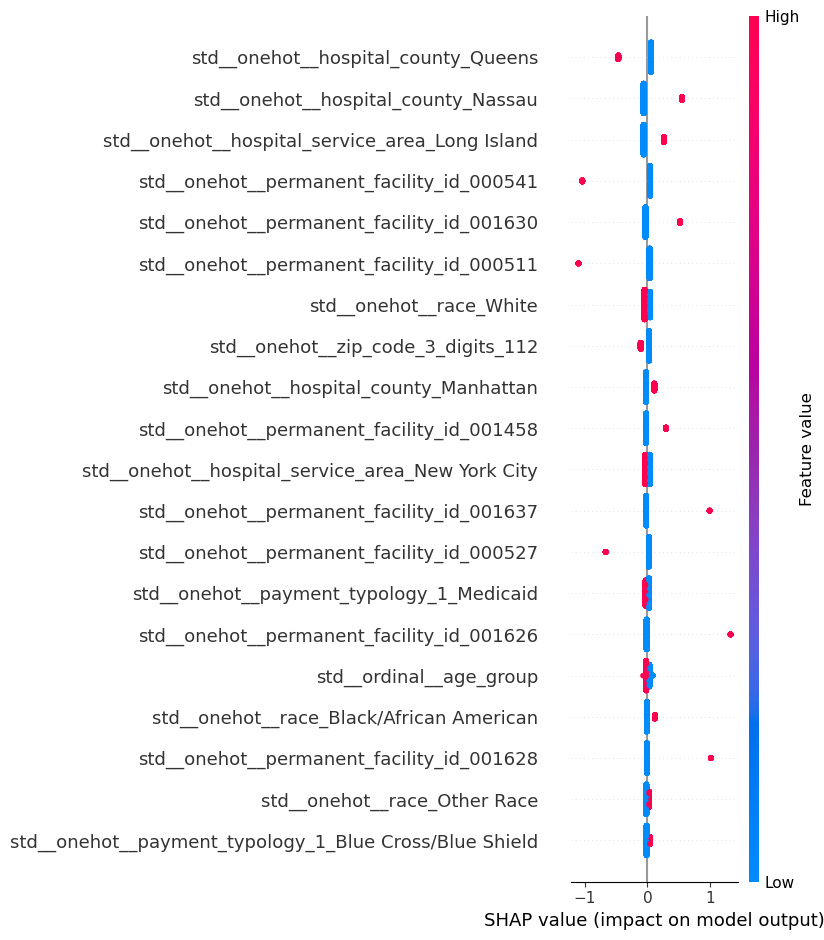

In [23]:
shap.summary_plot(shap_values, X_test, feature_names=prep_ftrs, plot_type = 'dot')

In [24]:
index = 10
shap.force_plot(explainer.expected_value, shap_values[index,:], features=X_test.iloc[index,:],feature_names=prep_ftrs)

In [25]:
index = 154
shap.force_plot(explainer.expected_value, shap_values[index,:], features=X_test.iloc[index,:],feature_names=prep_ftrs)